In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import os


## getting data ready

In [ ]:
train_dir = "/content/drive/MyDrive/ml/cat-dog-classification/train"
test_dir = "/content/drive/MyDrive/ml/cat-dog-classification/test"


In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
transform = weights.transforms()

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

In [ ]:
class_names = train_data.classes
class_names

['cats', 'dogs']

In [ ]:
# creating data batches
BATCH_SIZE = 32
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,num_workers=os.cpu_count())
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,num_workers=os.cpu_count())

## creating model

In [ ]:
# creating device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo

from torchinfo import summary
summary(model, input_size=(32, 3, 224, 224),
        col_names=("input_size", "output_size", "num_params", "trainable"),
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
for params in model.features.parameters():
  params.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=1, bias=True)
).to(device)


In [ ]:
summary(model,input_size=(32, 3, 224, 224),
        col_names=("input_size", "output_size", "num_params", "trainable"),
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## training the model

In [ ]:
# creating loss, optimizer and accuracy funciton
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
def train_model(model, train_dataloader, loss_fn, optimizer, device):

  train_loss, train_acc = 0,0

  for batch, (X,y) in enumerate(train_dataloader):
    model.train()
    X, y = X.to(device), y.to(device)

    y_logits = model(X).squeeze()

    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y.float())

    train_loss += loss
    train_acc += accuracy_fn(y, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  print(f"Train loss: {train_loss}, Train acc: {train_acc}")
  return{"train_loss":train_loss,
         "train_acc":train_acc}


In [ ]:
def test_model(model, test_dataloader, loss_fn, device):
  model.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0,0
    for batch, (X,y) in enumerate(test_dataloader):
      X, y = X.to(device), y.to(device)
      test_logits = model(X).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))
      test_loss += loss_fn(test_pred, y.float())
      test_acc += accuracy_fn(y, test_pred)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    print(f"Test loss: {test_loss}, Test acc: {test_acc}")
    return {
        "test_loss":test_loss,
        "test_acc":test_acc
    }

In [ ]:
from tqdm.auto import tqdm
def train(model, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device):

  results = {
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }

  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_data = train_model(model, train_dataloader, loss_fn, optimizer, device)
    results["train_loss"].append(train_data["train_loss"])
    results["train_acc"].append(train_data["train_acc"])

    test_data = test_model(model, test_dataloader, loss_fn, device)
    results["test_loss"].append(test_data["test_loss"])
    results["test_acc"].append(test_data["test_acc"])


  return results


In [ ]:
epochs = 10
results = train(model, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/557 samples
Train loss: 0.47636282444000244, Train acc: 84.12126068376068
Test loss: 0.5169616341590881, Test acc: 92.5
Epoch: 1
-------
Looked at 0/557 samples
Train loss: 0.27455583214759827, Train acc: 90.89209401709402
Test loss: 0.5107116103172302, Test acc: 93.75
Epoch: 2
-------
Looked at 0/557 samples
Train loss: 0.1989096701145172, Train acc: 93.92361111111111
Test loss: 0.5083373785018921, Test acc: 94.375
Epoch: 3
-------
Looked at 0/557 samples
Train loss: 0.19253502786159515, Train acc: 94.53792735042735
Test loss: 0.5083373785018921, Test acc: 94.375
Epoch: 4
-------
Looked at 0/557 samples
Train loss: 0.18776360154151917, Train acc: 93.6698717948718
Test loss: 0.5107116103172302, Test acc: 93.75
Epoch: 5
-------
Looked at 0/557 samples
Train loss: 0.1540031135082245, Train acc: 96.19391025641025
Test loss: 0.5044616460800171, Test acc: 95.0
Epoch: 6
-------
Looked at 0/557 samples
Train loss: 0.14937704801559448, Train acc: 96.00694444444444


In [ ]:
torch.save(model,"/content/drive/MyDrive/ml/cat-dog-classification/torch_model2.pt")

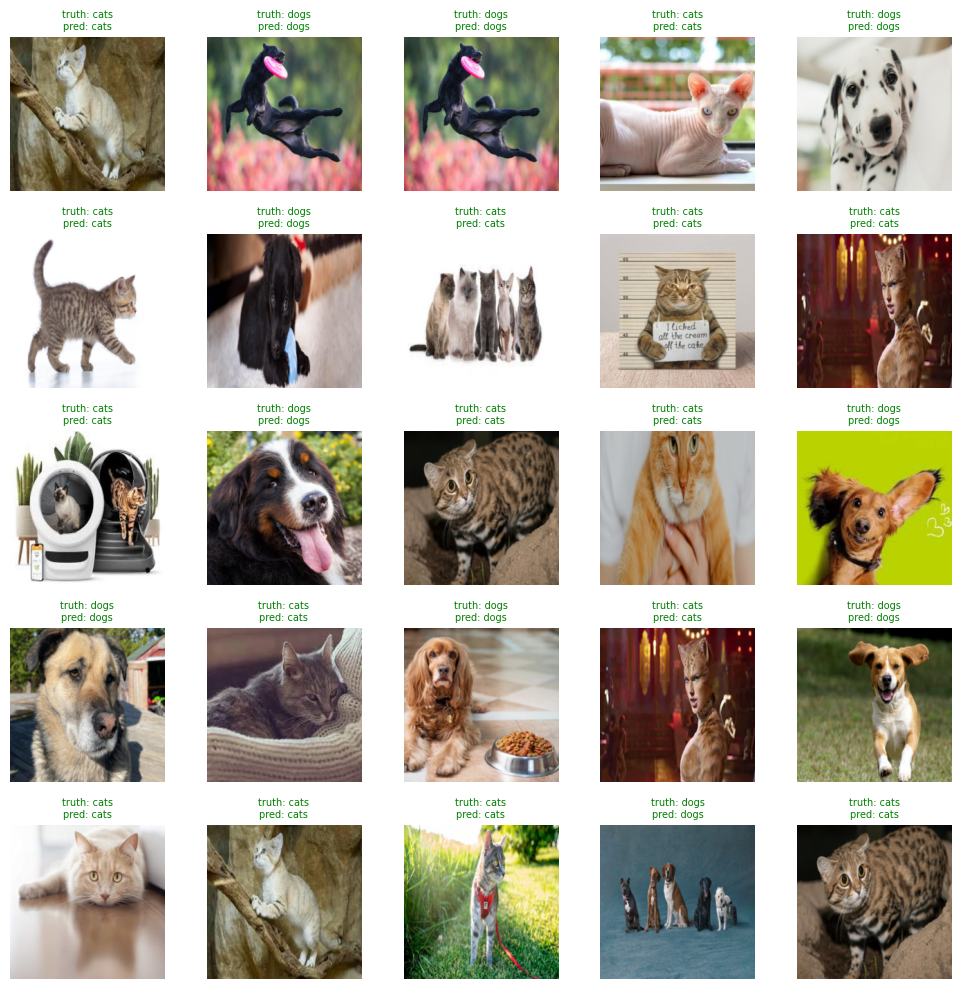

In [158]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random



def pred_and_plot(model, data_dir):
    model.eval()
    with torch.inference_mode():
        plt.figure(figsize=(10, 10))

        for i in range(25):
            # Randomly select a class folder and an image
            class_folder = random.choice(os.listdir(data_dir))
            class_path = os.path.join(data_dir, class_folder)
            image_name = random.choice(os.listdir(class_path))
            image_path = os.path.join(class_path, image_name)

            # Load the image
            img = Image.open(image_path)
            label = class_names.index(class_folder)

            # Transform the image
            transformed_image = transform(img)
            simple_transformed_image = simple_transform(img)

            # Perform prediction
            y_logits = model(transformed_image.unsqueeze(dim=0).to(device)).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits)).to(int).item()
            y_label = class_names[y_pred]
            y_true = class_names[label]

            # Plot the image
            plt.subplot(5, 5, i + 1)
            color = "green" if y_label == y_true else "red"
            plt.imshow(simple_transformed_image.permute(1, 2, 0))
            plt.title(f"truth: {y_true}\npred: {y_label}", color=color, fontsize=7)
            plt.axis("off")

        plt.tight_layout()
        plt.show()

# Call the function with the model and directory path
data_dir = "/content/drive/MyDrive/ml/cat-dog-classification/test"
pred_and_plot(model, data_dir)


In [ ]:
def eval_model(model, test_dataloader, loss_fn, device):
  model.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0,0
    test_preds = []
    for batch, (X,y) in enumerate(test_dataloader):
      X, y = X.to(device), y.to(device)
      test_logits = model(X).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))
      test_loss += loss_fn(test_pred, y.float())
      test_acc += accuracy_fn(y, test_pred)

      test_preds.append(test_pred)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    print(f"Test loss: {test_loss}, Test acc: {test_acc}")
    return {
        "test_loss":test_loss,
        "test_acc":test_acc,
        "test_pred":test_preds
    }


In [ ]:
y_true = torch.tensor([label for _,label in test_data])
result = eval_model(model, test_dataloader, loss_fn, device)
y_preds = torch.cat(result["test_pred"])

Test loss: 0.5020872950553894, Test acc: 95.625


In [ ]:
type(y_true), type(y_preds)

(torch.Tensor, torch.Tensor)

In [ ]:
try:
  import torchmetrics
except:
  !pip install torchmetrics

from torchmetrics.classification import BinaryConfusionMatrix

conf = BinaryConfusionMatrix()

mat = conf(y_preds, y_true)
mat

tensor([[66,  4],
        [ 3, 67]])

(<Figure size 500x500 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

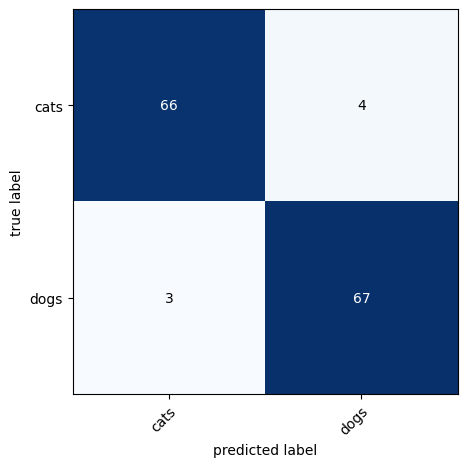

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
plot_confusion_matrix(conf_mat=mat.numpy(),
                      figsize=(5,5),
                      class_names=class_names)